<a href="https://colab.research.google.com/github/mayurtummewar/crypto-watermarking/blob/main/first_try.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
print(sys.version)

3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]


In [ ]:
!pip install pywavelets opencv-python

In [ ]:
import numpy as np
import pywt
import cv2
import matplotlib.pyplot as plt
from math import gcd

In [ ]:
plt.rcParams['figure.figsize'] = (6, 6)
np.set_printoptions(suppress=True, precision=4)

In [ ]:
WAVELET='db1'
DWT_LEVEL=3
PIXEL_MAX=255
MODULUS=256

In [ ]:
K=0.98
Q=0.02
KEY=37
assert gcd(KEY, MODULUS) == 1, "Key is not coprime with modulus!"

In [ ]:
def show_image(img, title="", cmap='gray'):
  plt.imshow(img, cmap=cmap)
  plt.title(title)
  plt.axis('off')
  plt.show()

In [ ]:
cover = cv2.imread("assets/cameraman_grayscale.png", cv2.IMREAD_GRAYSCALE)
watermark = cv2.imread("assets/sppu_logo.jpg", cv2.IMREAD_GRAYSCALE)

assert cover is not None, "Cover image not loaded"
assert watermark is not None, "Watermark image no loaded"

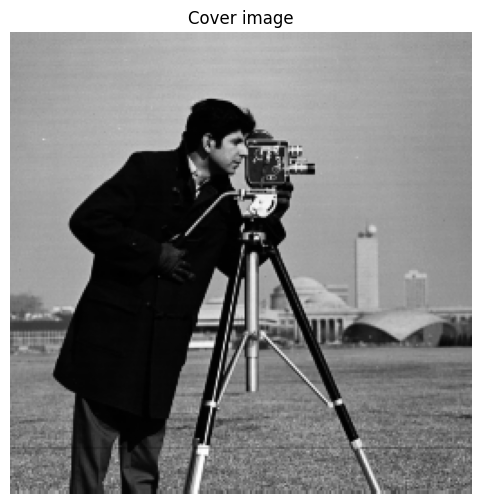

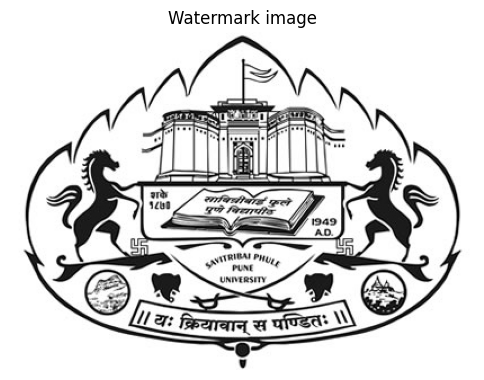

In [ ]:
show_image(cover, "Cover image")
show_image(watermark, "Watermark image")

In [ ]:
cover_f=np.float32(cover)
watermark_f=np.float32(watermark)

In [ ]:
coeffs_cover = pywt.wavedec2(
    cover_f,
    WAVELET,
    level=DWT_LEVEL
)

In [ ]:
LL3_cover = coeffs_cover[0]
(LH3, HL3, HH3) = coeffs_cover[1]

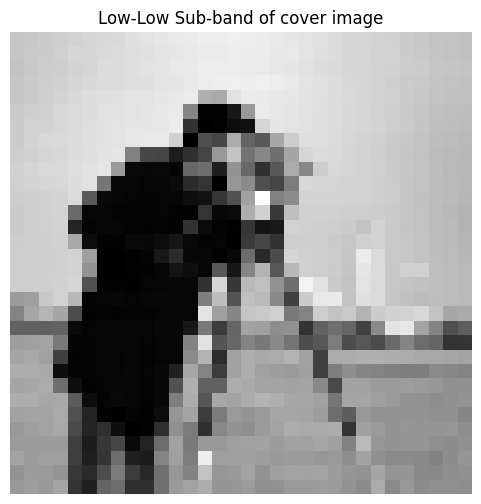

In [ ]:
show_image(LL3_cover, "Low-Low Sub-band of cover image")

In [ ]:
coeffs_wm = pywt.wavedec2(
    watermark,
    WAVELET,
    level=DWT_LEVEL
)

In [ ]:
LL3_wm = coeffs_wm[0]

In [ ]:
LL3_wm_original = LL3_wm.copy()
LL3_wm = cv2.resize(LL3_wm, (LL3_cover.shape[1], LL3_cover.shape[0]))

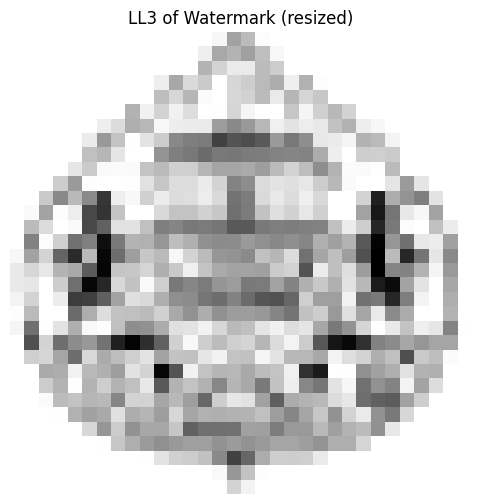

In [ ]:
show_image(LL3_wm, "LL3 of Watermark (resized)")

In [ ]:
print(LL3_cover.shape, LL3_wm.shape)

(32, 32) (32, 32)


In [ ]:
print(f"K (imperceptibility) = {K}")
print(f"Q (robustness)       = {Q}")

K (imperceptibility) = 0.98
Q (robustness)       = 0.02


In [ ]:
LL3_embedded = (K*LL3_cover)+(Q*LL3_wm)

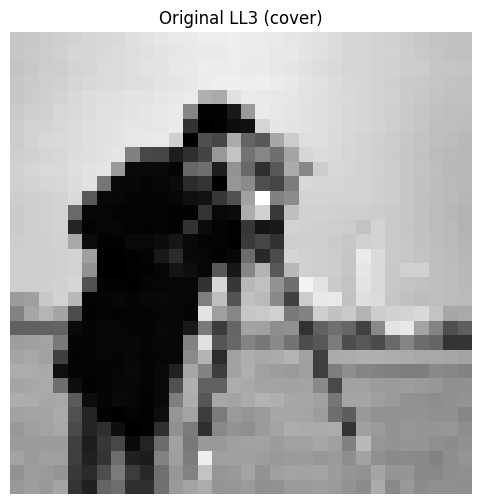

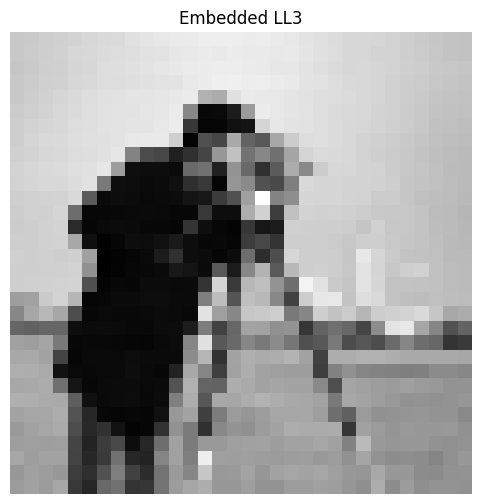

In [ ]:
show_image(LL3_cover, "Original LL3 (cover)")
show_image(LL3_embedded, "Embedded LL3")

In [ ]:
coeffs_cover_embedded = list(coeffs_cover)
coeffs_cover_embedded[0] = LL3_embedded

In [ ]:
watermarked_f = pywt.waverec2(
    coeffs_cover_embedded,
    WAVELET
)

In [ ]:
watermarked = np.clip(watermarked_f, 0, PIXEL_MAX).astype(np.uint8)

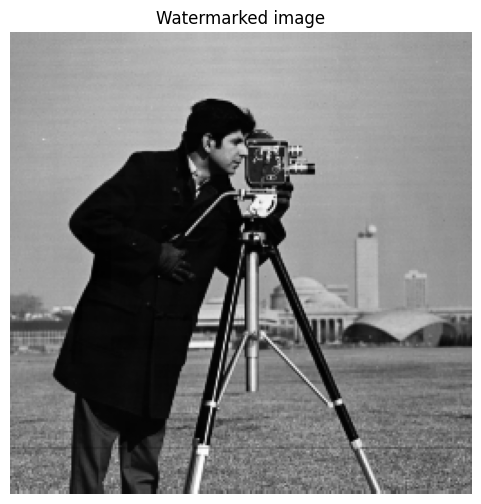

In [ ]:
show_image(watermarked, "Watermarked image")

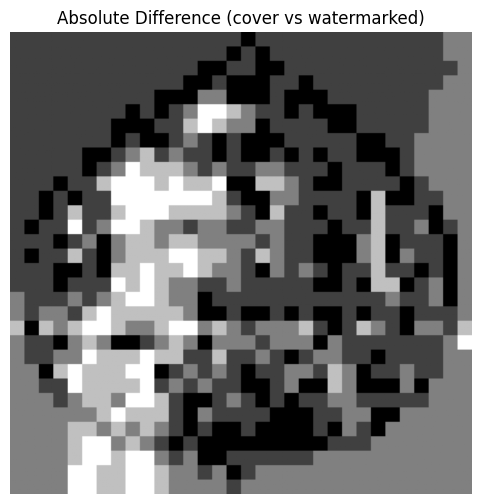

In [ ]:
diff_image = cv2.absdiff(cover, watermarked)
show_image(diff_image, "Absolute Difference (cover vs watermarked)")

In [ ]:
cv2.imwrite("watermarked.png", watermarked)

True

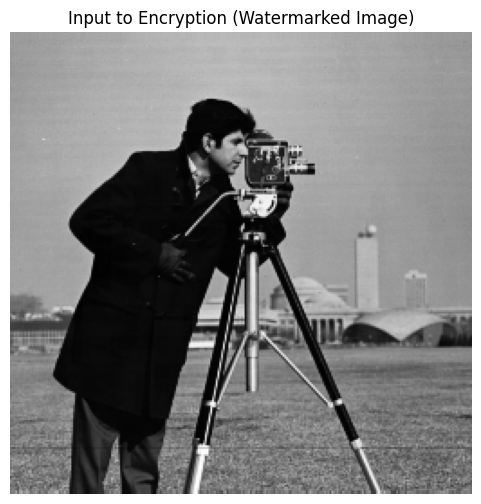

In [ ]:
show_image(watermarked, "Input to Encryption (Watermarked Image)")

In [ ]:
print("Encryption key :", KEY)
print("Modulus        :", MODULUS)

Encryption key : 37
Modulus        : 256


In [ ]:
watermarked_int = watermarked.astype(np.int32)

In [ ]:
encrypted_int = (watermarked_int * KEY) % MODULUS
encrypted = encrypted_int.astype(np.uint8)

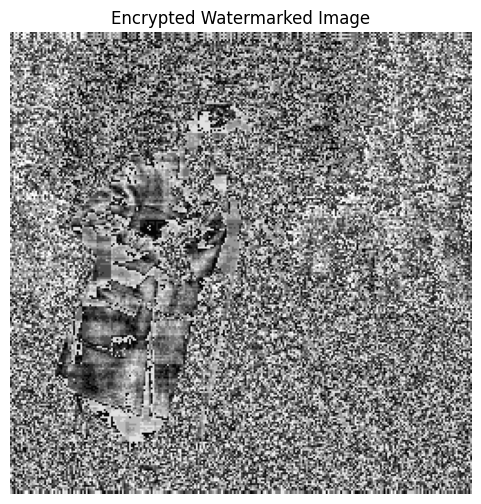

In [ ]:
show_image(encrypted, "Encrypted Watermarked Image")

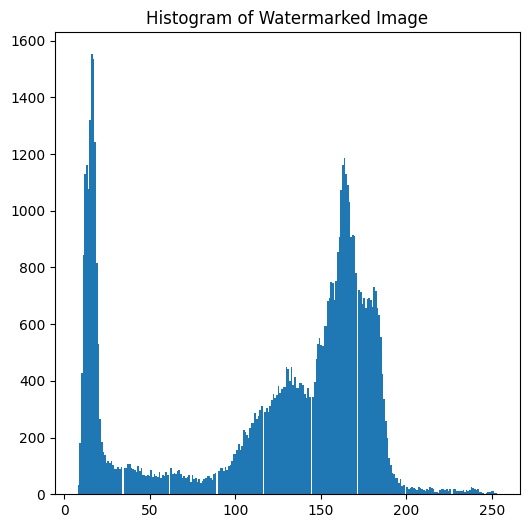

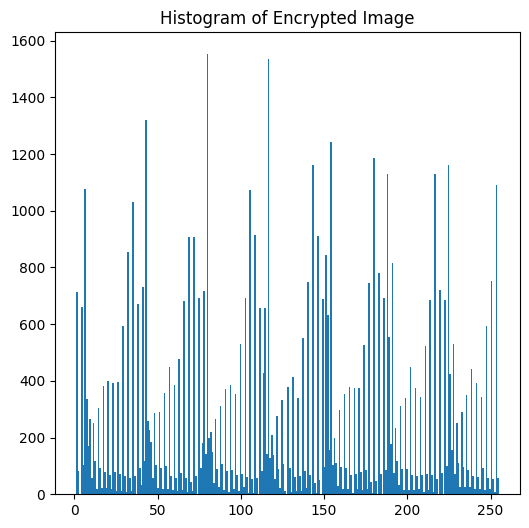

In [ ]:
plt.figure()
plt.hist(watermarked.flatten(), bins=256)
plt.title("Histogram of Watermarked Image")
plt.show()

plt.figure()
plt.hist(encrypted.flatten(), bins=256)
plt.title("Histogram of Encrypted Image")
plt.show()

In [ ]:
cv2.imwrite("encrypted.png", encrypted)

True

In [ ]:
KEY_INV = pow(KEY, -1, MODULUS)
print("Modular inverse of KEY:", KEY_INV)

Modular inverse of KEY: 173


In [ ]:
encrypted_int = encrypted.astype(np.int32)
decrypted_int = (encrypted_int * KEY_INV) % MODULUS
decrypted = decrypted_int.astype(np.uint8)


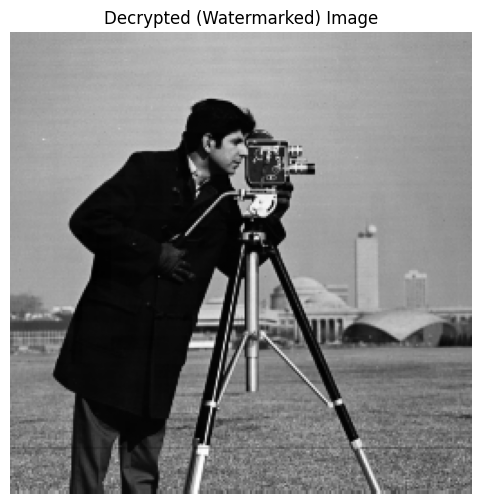

In [ ]:
show_image(decrypted, "Decrypted (Watermarked) Image")

In [ ]:
decryption_loss = cv2.absdiff(watermarked, decrypted)
print("Max pixel difference:", decryption_loss.max())

Max pixel difference: 0


In [ ]:
cv2.imwrite("decrypted.png", decrypted)

True

In [ ]:
decrypted_f = np.float32(decrypted)

coeffs_dec = pywt.wavedec2(
    decrypted_f,
    WAVELET,
    level=DWT_LEVEL
)

LL3_dec = coeffs_dec[0]

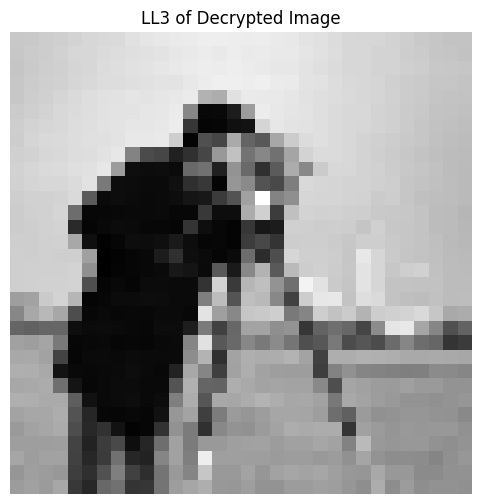

In [ ]:
show_image(LL3_dec, "LL3 of Decrypted Image")
LL3_wm_extracted = (LL3_dec - (K * LL3_cover)) / Q

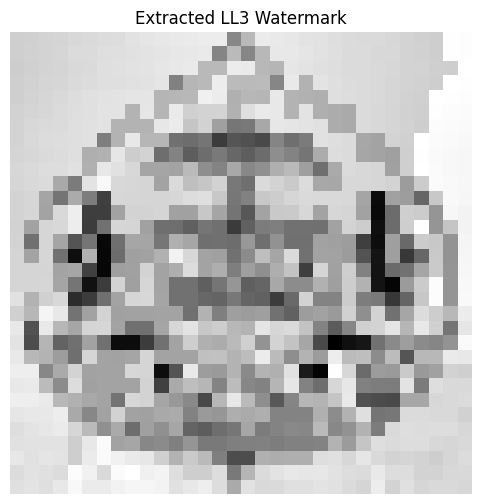

In [ ]:
show_image(LL3_wm_extracted, "Extracted LL3 Watermark")

In [ ]:
coeffs_wm_extracted = list(coeffs_dec)
coeffs_wm_extracted[0] = LL3_wm_extracted

In [ ]:

watermark_extracted_f = pywt.waverec2(
    coeffs_wm_extracted,
    WAVELET
)

In [ ]:
watermark_extracted = np.clip(
    watermark_extracted_f,
    0,
    PIXEL_MAX
).astype(np.uint8)

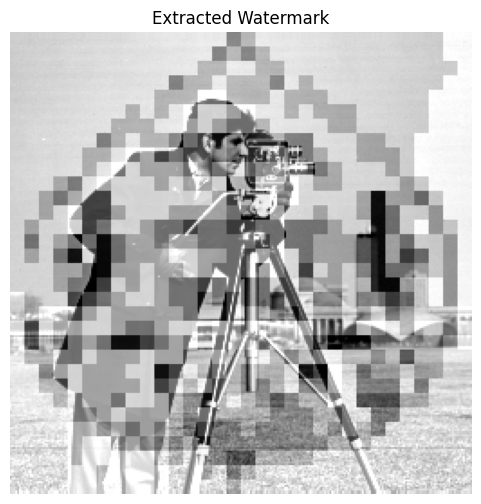

In [ ]:
show_image(watermark_extracted, "Extracted Watermark")